# Context

in this notebook we are trying to optimise the best model form the selection phase to better target each different phylum. In that sense we are splitting the training and the modeling for the different phylumns  

# Imports

In [1]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/rare_species 1.zip'
extract_path = '/content/rare_species 1'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [21]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Rescaling, RandAugment

from sklearn.metrics import classification_report

In [4]:
# With colab
folder_path = '/content/rare_species 1/rare_species 1'
meta = pd.read_csv('/content/rare_species 1//metadata.csv')

# With vscode
# folder_path = '../data/rare_species 1'
# meta = pd.read_csv('../data/rare_species 1/metadata.csv')

In [5]:
print(f"the diferent Phylum are: \n{meta['phylum'].unique()}")
print(f"each phylum contains :  \n{meta['phylum'].value_counts()}")

print(f"their is {meta['family'].nunique()} different families")

meta

the diferent Phylum are: 
['mollusca' 'chordata' 'arthropoda' 'echinodermata' 'cnidaria']
each phylum contains :  
phylum
chordata         9952
arthropoda        951
cnidaria          810
mollusca          210
echinodermata      60
Name: count, dtype: int64
their is 202 different families


,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...
...,...,...,...,...,...,...,...
11978,1fa96ea5-32fa-4a25-b8d2-fa99f6e2cb89,29734618,1011315,animalia,chordata,leporidae,chordata_leporidae/29734618_1011315_eol-full-s...
11979,628bf2b4-6ecc-4017-a8e6-4306849e0cfc,29972861,1056842,animalia,chordata,emydidae,chordata_emydidae/29972861_1056842_eol-full-si...
11980,0ecfdec9-b1cd-4d43-96fc-2f8889ec1ad9,30134195,52572074,animalia,chordata,dasyatidae,chordata_dasyatidae/30134195_52572074_eol-full...
11981,27fdb1e9-c5fb-459a-8b6a-6fb222b1c512,9474963,46559139,animalia,chordata,mustelidae,chordata_mustelidae/9474963_46559139_eol-full-...


# Phylum Splits

This code splits the species into separate folders based on their phylum.  
This organization allows us to train a dedicated model for each phylum more effectively.<br>
(we repeat this proses in each notebook only because we are using colab)

In [7]:
# With colab
current_locations = '/content/rare_species 1'

# with vscode
# current_locations = '../data/rare_species 1'

for _, row in meta.iterrows():

    phylum = row['phylum']
    file_path = row['file_path']


    file_location = os.path.join(current_locations, file_path)

    # create a a detination folder keeping the subfolder structure

        # with colab
    target_folder = os.path.join(phylum, os.path.dirname(file_path))

        # with vscode
    # target_folder = os.path.join("../data" , phylum, os.path.dirname(file_path))

    os.makedirs(target_folder, exist_ok=True)  # Make sure the folder exists

    # Final destination path
    destination = os.path.join(target_folder, os.path.basename(file_path))

    # Copy the file if it exists
    if os.path.exists(file_location):
        shutil.copy2(file_location, destination)
    else:
        print(f"Couldn't find the file: {file_location}")

# Train Val Split

In [13]:
# with colab
path_phylum_cnidaria = "/content/cnidaria"


# with vscode
# path_phylum_chordata = "../data/chordata"


image_size = (224, 224)
seed = 42
batch_size = 32


train_ds_cnidaria, val_ds_cnidaria = keras.utils.image_dataset_from_directory(
    path_phylum_cnidaria,
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size= image_size,
    batch_size= batch_size
)


Found 810 files belonging to 13 classes.
Using 648 files for training.
Using 162 files for validation.


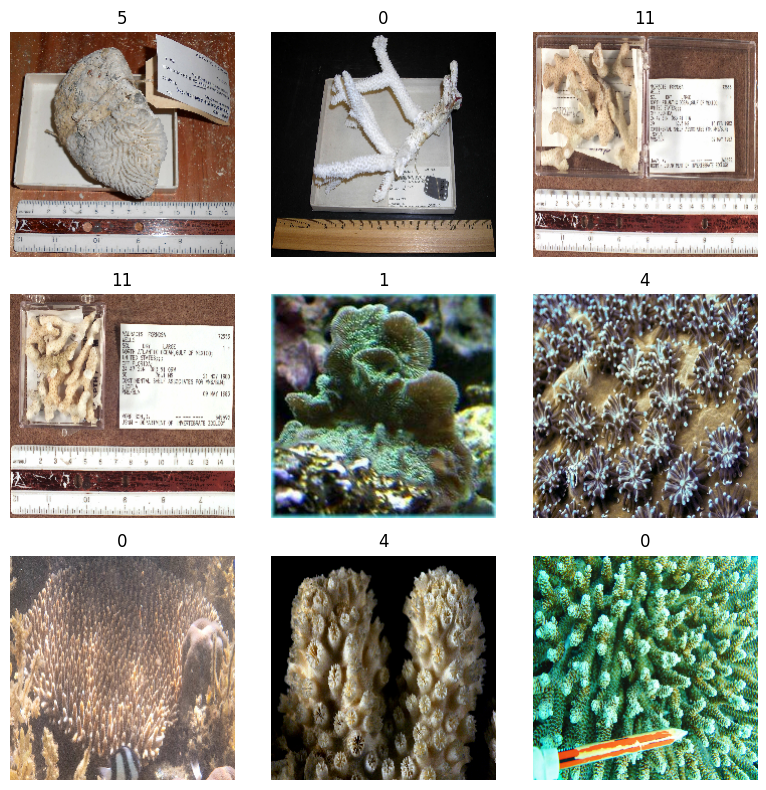

In [15]:
def display_images(train_ds):
    for images, labels in train_ds.take(1):
        plt.figure(figsize=(8, 8))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
        plt.tight_layout()
        plt.show()

display_images(train_ds_cnidaria)

# Augmentation layer

In [16]:
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

In [17]:
data_augmentation_layers = [
    RandAugment(value_range= (0, 255))
 ## add any you want here
]

# Model

In [24]:
## to be adapted to the new dataset
def make_model_mobilenetv2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = data_augmentation(inputs) # Remove the extra (inputs) call here
    x = Rescaling(1./255)(x)

    # Pretrained MobileNetV2 base
    base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

<ipython-input-24-d419b3ffd73d>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


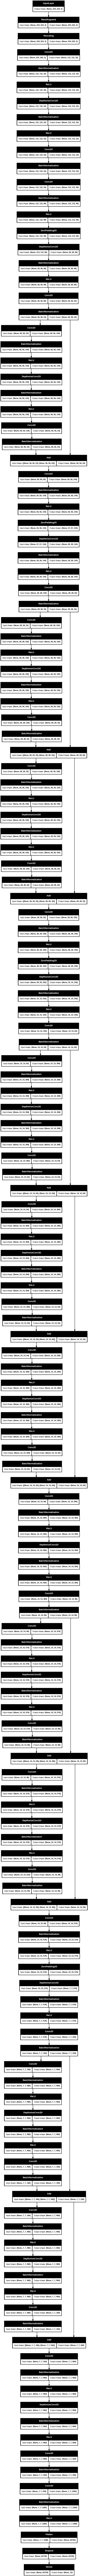

In [25]:
model_cnidaria = make_model_mobilenetv2(input_shape=image_size + (3,), num_classes=13)
keras.utils.plot_model(model_cnidaria, show_shapes=True)

# Run and evaluation

In [26]:
epochs = 20

# make the learning rate change over the epochs to avoid getting stuck
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=10000,
    decay_rate=0.9
)

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_cnidaria.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from kera example is the loss function as we deal with a lot of classes
model_cnidaria.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_cnidaria.fit(
    train_ds_cnidaria,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_cnidaria,
)

# get the clasification report
best_model_example = keras.models.load_model("best_model_chordata.keras")
y_pred_probs = best_model_example.predict(val_ds_cnidaria)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds_cnidaria], axis=0)

print(classification_report(y_true, y_pred))

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.2435 - loss: 4.9331
Epoch 1: val_acc improved from -inf to 0.38889, saving model to best_model_cnidaria.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - acc: 0.2478 - loss: 4.8985 - val_acc: 0.3889 - val_loss: 3.1593
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.7110 - loss: 1.0551
Epoch 2: val_acc improved from 0.38889 to 0.50000, saving model to best_model_cnidaria.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - acc: 0.7130 - loss: 1.0470 - val_acc: 0.5000 - val_loss: 2.6491
Epoch 3/20
 6/21 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - acc: 0.8719 - loss: 0.4575

KeyboardInterrupt: 

--------
Whole Pipeline with 3 different models

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report


In [31]:
img_size = (224, 224)
batch_size = 32


AUTOTUNE = tf.data.AUTOTUNE
#train_ds_ = train_ds.prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
num_classes = len(train_ds_cnidaria.class_names)


In [32]:
augmentation_variants = {
    "simple": keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
    ]),
    "heavy": keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.3),
        layers.RandomContrast(0.2),
    ])
}


In [33]:
model_candidates = {
    "MobileNetV2": keras.applications.MobileNetV2,
    "EfficientNetB0": keras.applications.EfficientNetB0,
    "ResNet50": keras.applications.ResNet50
}


In [34]:
results = []
best_val_acc = 0
best_model_path = ""


In [35]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed


In [ ]:
epochs = 20

for aug_name, augmenter in augmentation_variants.items():
    for model_name, backbone_fn in model_candidates.items():
        print(f"Training {model_name} with {aug_name} augmentation")

        base_model = backbone_fn(input_shape=img_size + (3,), include_top=False, weights="imagenet")
        base_model.trainable = False

        inputs = keras.Input(shape=img_size + (3,))
        x = augmenter(inputs)
        x = keras.applications.imagenet_utils.preprocess_input(x)
        x = base_model(x, training=False)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)

        model = keras.Model(inputs, outputs)

        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=3e-4,
            decay_steps=1000,
            decay_rate=0.9
        )

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=focal_loss(gamma=2, alpha=0.25),
            metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
        )

        checkpoint_path = f"model_{model_name}_{aug_name}.keras"
        callbacks = [
            keras.callbacks.ModelCheckpoint(checkpoint_path,
                                            save_best_only=True,
                                            monitor="val_acc",
                                            mode="max",
                                            verbose=0)
        ]

        history = model.fit(
            train_ds_cnidaria,
            epochs=epochs,
            validation_data=val_ds_cnidaria,
            callbacks=callbacks,
            verbose=0
        )

        val_acc = max(history.history['val_acc'])
        best_epoch = np.argmax(history.history['val_acc']) + 1
        final_loss = history.history['loss'][-1]

        results.append({
            "Model": model_name,
            "Augmentation": aug_name,
            "Val Accuracy": val_acc,
            "Best Epoch": best_epoch,
            "Final Loss": final_loss,
            "Checkpoint": checkpoint_path
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = checkpoint_path


Training MobileNetV2 with simple augmentation


In [ ]:
results_df = pd.DataFrame(results)
results_df.sort_values("Val Accuracy", ascending=False, inplace=True)
print(results_df)
results_df.to_csv("benchmark_results.csv", index=False)


In [ ]:
import shutil
shutil.copyfile(best_model_path, "best_model_cnidaria_final.keras")
